In [12]:
import pandas as pd
import numpy as np
from ngboost import NGBRegressor
import xarray as xr

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

### Example from NGBoost documentation

In [123]:
# Load Boston housing dataset
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
X = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
Y = raw_df.values[1::2, 2]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

ngb = NGBRegressor().fit(X_train, Y_train)
Y_preds = ngb.predict(X_test)
Y_dists = ngb.pred_dist(X_test)

# test Mean Squared Error
test_MSE = mean_squared_error(Y_preds, Y_test)
print('Test MSE', test_MSE)

# test Negative Log Likelihood
test_NLL = -Y_dists.logpdf(Y_test).mean()
print('Test NLL', test_NLL)

[iter 0] loss=3.6290 val_loss=0.0000 scale=1.0000 norm=6.6430
[iter 100] loss=2.6863 val_loss=0.0000 scale=2.0000 norm=4.8788
[iter 200] loss=2.1272 val_loss=0.0000 scale=2.0000 norm=3.2859
[iter 300] loss=1.8667 val_loss=0.0000 scale=1.0000 norm=1.4252
[iter 400] loss=1.7432 val_loss=0.0000 scale=1.0000 norm=1.3271
Test MSE 11.0797859714513
Test NLL 4.003719676484786


In [4]:
# base = '/Users/jwu/Work/Dabble/MLFLUXES-main/data/'
base = '/Users/jwu/Work/Code/mlflux/data/'
ds = xr.open_dataset(base+'WHOI/EUREC4A_ATOMIC_RonBrown_10min_nav_met_sea_flux_20200109-20200212_v1.3.nc')
ds_clean = ds.dropna(dim="obs", how="any", subset=["tau_streamwise_cov","tau_bulk","wspd"])
X = ds_clean.wspd.values.astype('float32')
Y = ds_clean.tau_streamwise_cov.values.astype('float32')

In [29]:
# import pickle
# XY = np.stack((X.squeeze(),Y.squeeze()), axis=1)
# file = open('XandY.pkl', 'wb')
# pickle.dump(XY, file)
# file = open('XandY.pkl', 'rb')
# XYload = pickle.load(file)

In [ ]:
# def __init__(
#     self,
#     Dist=Normal,
#     Score=LogScore,
#     Base=default_tree_learner,
#     natural_gradient=True,
#     n_estimators=500,
#     learning_rate=0.01,
#     minibatch_frac=1.0,
#     col_sample=1.0,
#     verbose=True,
#     verbose_eval=100,
#     tol=1e-4,
#     random_state=None,
#     validation_fraction=0.1,
#     early_stopping_rounds=None,)

### Binned stats


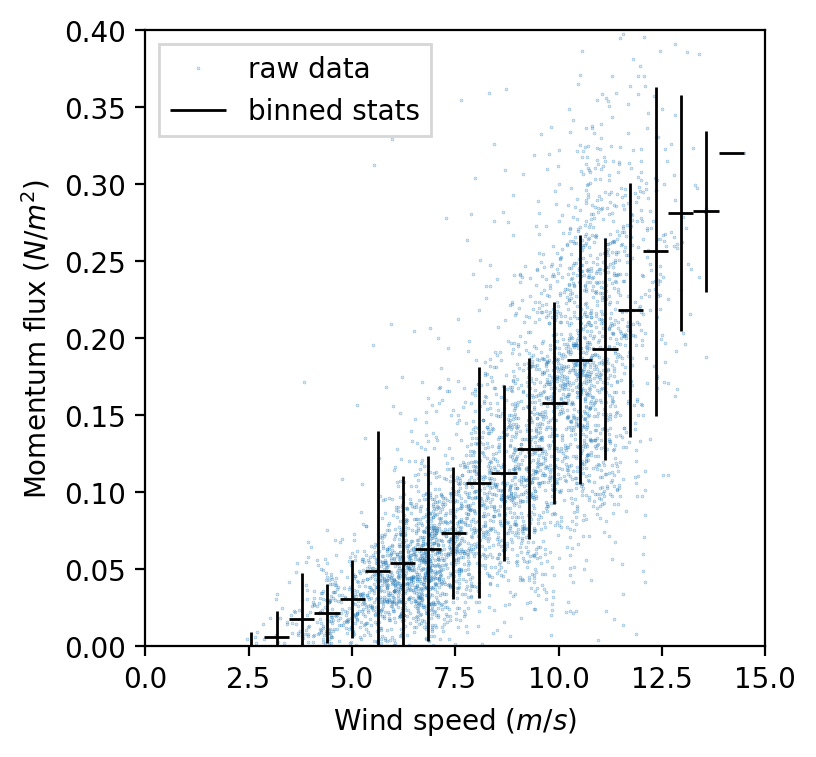

In [120]:
bin_means, bin_edges, binnumber = stats.binned_statistic(X.squeeze(), Y.squeeze(), 
                                                         statistic='mean', bins=20)
bin_stds, bin_edges, binnumber = stats.binned_statistic(X.squeeze(), Y.squeeze(), 
                                                         statistic='std', bins=20)
plt.figure(figsize=[4,4],dpi=200)
plt.xlabel(r'Wind speed ($m/s$)'); plt.ylabel('Momentum flux ($N/m^2$)')
plt.ylim([-0.,0.4]); plt.xlim([0,15])

plt.plot(X, Y, '.', label='raw data', markersize=0.5, alpha=0.5)
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='k', lw=1,
           label='binned stats')
plt.vlines((bin_edges[:-1]+bin_edges[1:])/2, bin_means+bin_stds, bin_means-bin_stds, 
           colors='k', lw=1)
plt.legend(loc='upper left', fancybox=False)

### NGBoost

#### First attempts 

In [52]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor

''' https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html#sklearn.gaussian_process.GaussianProcessRegressor

'''
learner = DecisionTreeRegressor(criterion='friedman_mse', max_depth=1)
# learner = GaussianProcessRegressor()

ngb = NGBRegressor(Base=learner, n_estimators=500, learning_rate=0.01)

ngb.fit(X_train, Y_train)
Y_preds = ngb.predict(X_test)
Y_dists = ngb.pred_dist(X_test)

/Users/jwu/miniconda3/envs/mlflux/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[iter 0] loss=-0.9686 val_loss=0.0000 scale=1.0000 norm=0.4967
[iter 100] loss=-1.1952 val_loss=0.0000 scale=1.0000 norm=0.5059
[iter 200] loss=-1.2978 val_loss=0.0000 scale=2.0000 norm=1.1388
[iter 300] loss=-1.3473 val_loss=0.0000 scale=1.0000 norm=0.6039
[iter 400] loss=-1.3684 val_loss=0.0000 scale=1.0000 norm=0.6149


In [115]:
x_uniform = np.linspace(0,15,100)
y_mean = ngb.predict(x_uniform.reshape(-1, 1))
y_dists = ngb.pred_dist(x_uniform.reshape(-1, 1))

(0.0, 0.4)

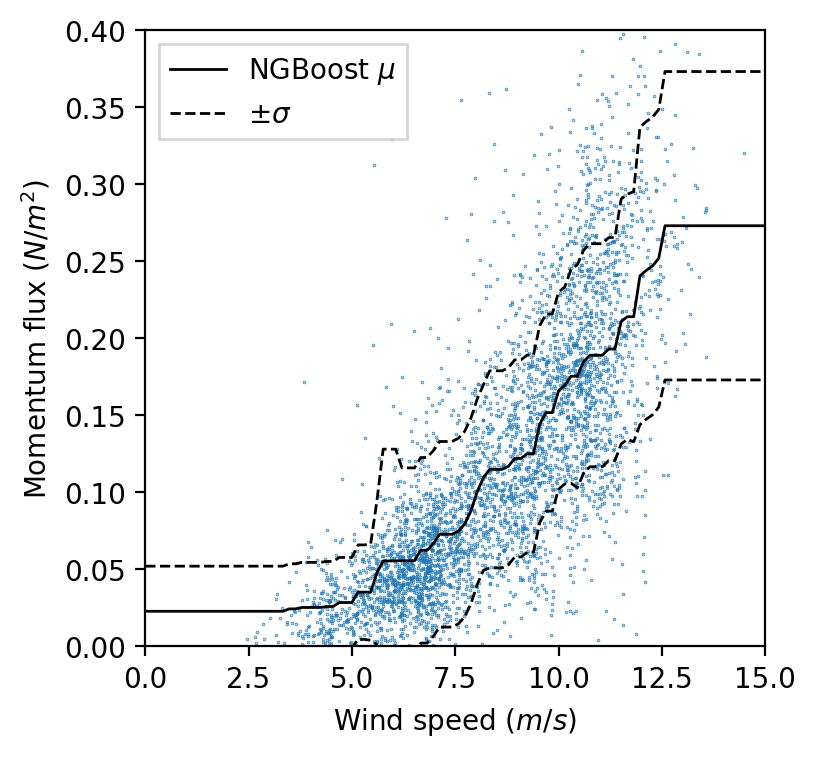

In [122]:
from matplotlib import pyplot as plt

plt.figure(figsize=[4,4],dpi=200)
plt.xlabel(r'Wind speed ($m/s$)'); plt.ylabel('Momentum flux ($N/m^2$)')
plt.ylim([-0.1,1]); plt.xlim([0,15])

plt.plot(X, Y, '.', markersize=0.5)
plt.plot(x_uniform, y_mean, '-', lw=1, color='k', label='NGBoost $\mu$')
plt.plot(x_uniform, y_mean-y_dists.var**0.5,'--', lw=1, color='k', label='$\pm \sigma$')
plt.plot(x_uniform, y_mean+y_dists.var**0.5,'--', lw=1, color='k')

plt.legend(loc='upper left', fancybox=False)
plt.xlim([0,15]); plt.ylim([0,0.4])

In [ ]:
# Try to keep the number of points in each bin the same?

#### Train on PSD data

In [65]:
base = '/Users/jwu/Work/Code/mlflux/data/'
ds = xr.load_dataset(base+'PSD/fluxes_all_cruises_compilation.nc')
ds_clean = ds.dropna(dim="time", how="any", 
                     subset=['taucx','taucy','hsc','hlc','U','tsnk','ta','qa'])

(0.0, 1.05)

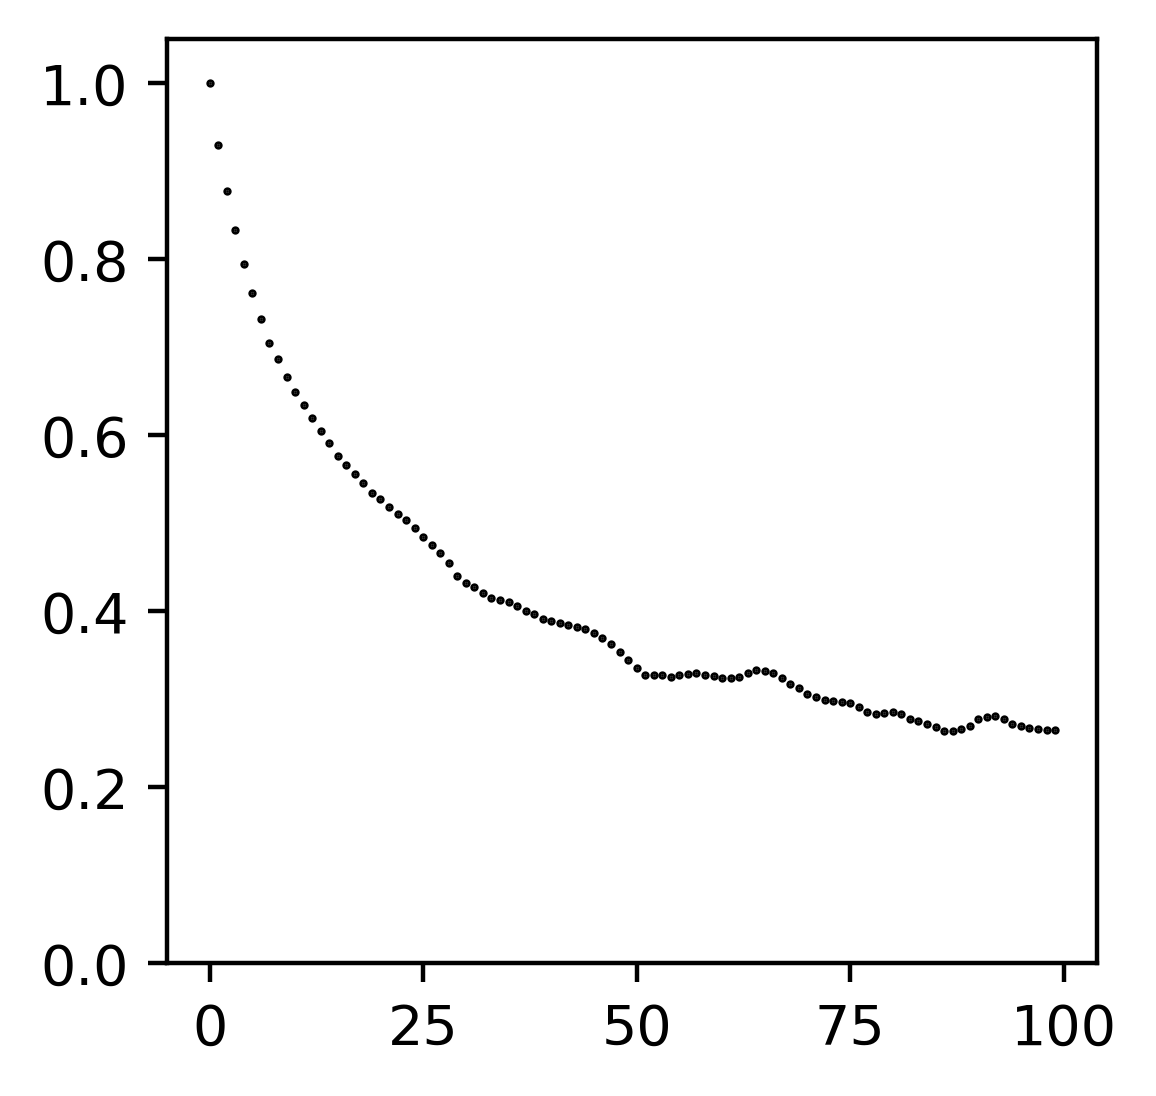

In [87]:
plt.figure(figsize=[3,3],dpi=400)
plt.plot(0, np.corrcoef(ds_clean.U.values, ds_clean.U.values)[0,1], '.', markersize=1, c='k')
for i in range(1,100):
    x = ds_clean.U.values[i:]
    y = ds_clean.U.values[:-i]
    corr_coef = np.corrcoef(x, y)
    plt.plot(i, corr_coef[0,1], '.', markersize=1, c='k')
plt.ylim([0,1.05])

In [22]:
from ngboost import NGBRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = np.hstack([np.reshape(ds_clean.U.values.astype('float32'),(-1,1)), np.reshape(ds_clean.tsnk.values.astype('float32'),(-1,1)),
               np.reshape(ds_clean.ta.values.astype('float32'),(-1,1)), np.reshape(ds_clean.qa.values.astype('float32'),(-1,1))])
Y = np.hstack([np.reshape(ds_clean.taucx.values.astype('float32'),(-1,1)), 
               np.reshape(ds_clean.taub.values.astype('float32'),(-1,1))])


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor

''' https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html#sklearn.gaussian_process.GaussianProcessRegressor

'''
learner = DecisionTreeRegressor(criterion='friedman_mse', max_depth=2)
# learner = GaussianProcessRegressor()

ngb = NGBRegressor(Base=learner, n_estimators=500, learning_rate=0.01)

ngb.fit(X_train, Y_train[:,0])
Y_preds = ngb.predict(X_test)
Y_dists = ngb.pred_dist(X_test)

[iter 0] loss=-0.7687 val_loss=0.0000 scale=1.0000 norm=0.7100
[iter 100] loss=-1.7049 val_loss=0.0000 scale=2.0000 norm=0.9072
[iter 200] loss=-1.9820 val_loss=0.0000 scale=2.0000 norm=1.0259
[iter 300] loss=-2.0544 val_loss=0.0000 scale=1.0000 norm=0.5513
[iter 400] loss=-2.0815 val_loss=0.0000 scale=2.0000 norm=1.1176


In [33]:
Y_dists.std()

array([0.03176316, 0.01690422, 0.0279007 , ..., 0.03465415, 0.02848938,
       0.01601815])

In [47]:
from scipy.stats import norm
Y_draws = []
for i in range(0,len(Y_preds)):
    draw = norm.rvs(size=1, loc=Y_dists.mean()[i], scale=Y_dists.std()[i])
    Y_draws.append(draw)
Y_draws = np.array(Y_draws).squeeze()

In [59]:
Y_res_norm = (Y_test[:,0] - Y_dists.mean())/Y_dists.std()
print(Y_res_norm.mean(), Y_res_norm.var())

-0.009673973043675347 1.3457707235208571


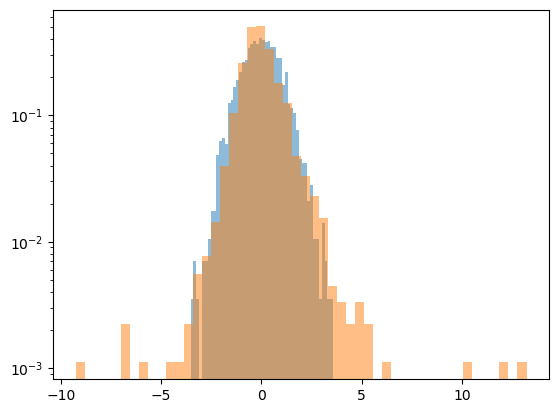

In [79]:
standard_normal = np.random.randn(Y_res_norm.size);
plt.hist(standard_normal, bins=50, alpha=0.5, density=True);
plt.hist(Y_res_norm, bins=50, alpha=0.5, density=True);
plt.yscale('log')
#x = np.linspace(-10,10,100)
#plt.plot()

In [84]:
import scipy
scipy.stats.wasserstein_distance(Y_res_norm, standard_normal)

0.1825094859776693

#### Test on ATOMIC data

In [81]:
ds = xr.open_dataset(base+'WHOI/EUREC4A_ATOMIC_RonBrown_10min_nav_met_sea_flux_20200109-20200212_v1.3.nc')
atomic = ds.dropna(dim="obs", how="any",
                   subset=["tau_streamwise_cov","tau_bulk","wspd",'tsea','tair','qair'])
X_test = np.hstack([np.reshape(atomic.wspd.values.astype('float32'),(-1,1)), 
               np.reshape(atomic.tsea.values.astype('float32'),(-1,1)),
               np.reshape(atomic.tair.values.astype('float32'),(-1,1)), 
               np.reshape(atomic.qair.values.astype('float32'),(-1,1))])
Y_test = np.hstack([np.reshape(atomic.tau_streamwise_cov.values.astype('float32'),(-1,1)), 
               np.reshape(atomic.tau_bulk.values.astype('float32'),(-1,1))])


In [88]:
Y_preds = ngb.predict(X_test)
Y_dists = ngb.pred_dist(X_test)

Y_res_norm = (Y_test[:,0] - Y_dists.mean())/Y_dists.std()
print(Y_res_norm.mean(), Y_res_norm.var())

MSE = 

0.06409319001651792 3.1677623935816523


In [ ]:
standard_normal = np.random.randn(Y_res_norm.size);
plt.hist(standard_normal, bins=50, alpha=0.5, density=True);
plt.hist(Y_res_norm, bins=50, alpha=0.5, density=True);
plt.yscale('log')

### Gaussian process

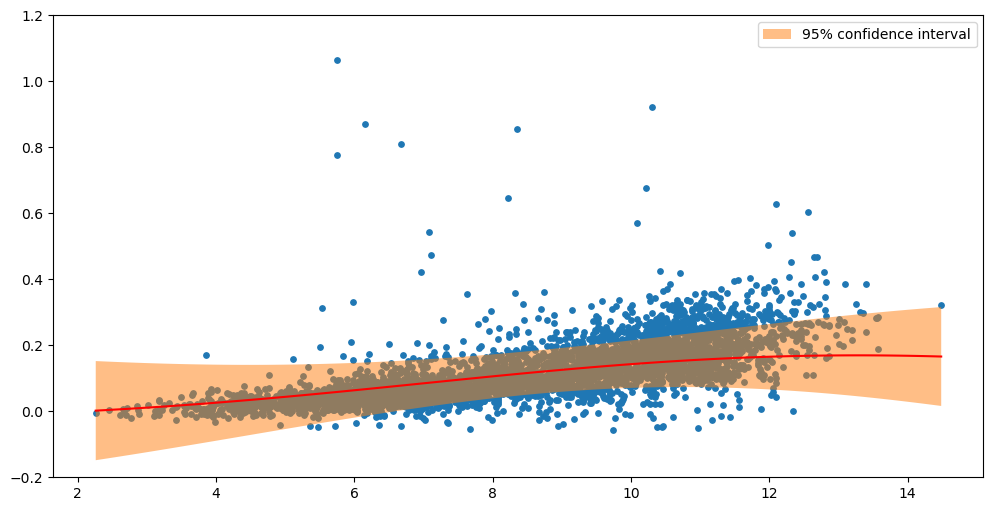

In [50]:
import pickle
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
import numpy as np
from sklearn.gaussian_process.kernels import RBF

file = open('XandY.pkl', 'rb')
data = pickle.load(file)
file.close()


kernel = 1 * RBF(length_scale=1, length_scale_bounds=(1e-2, 1e2))
gpr = GaussianProcessRegressor(kernel=kernel,random_state=0,alpha=2**2).fit(data[:,0].reshape(-1, 1), data[:,1].reshape(-1, 1))

## x array for predictions
x = np.linspace(min(data[:,0]),max(data[:,0]),100)
mean_prediction, std_prediction = gpr.predict(x.reshape(-1, 1), return_std=True)

plt.figure(figsize=(12,6))
plt.scatter(data[:,0],data[:,1],s=15)
plt.plot(x,mean_prediction.flatten(),color="red")
plt.fill_between(
    x,
    mean_prediction - 1.96 * abs(std_prediction),
    mean_prediction + 1.96 * abs(std_prediction),
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.ylim(-0.2,1.2)
plt.legend()